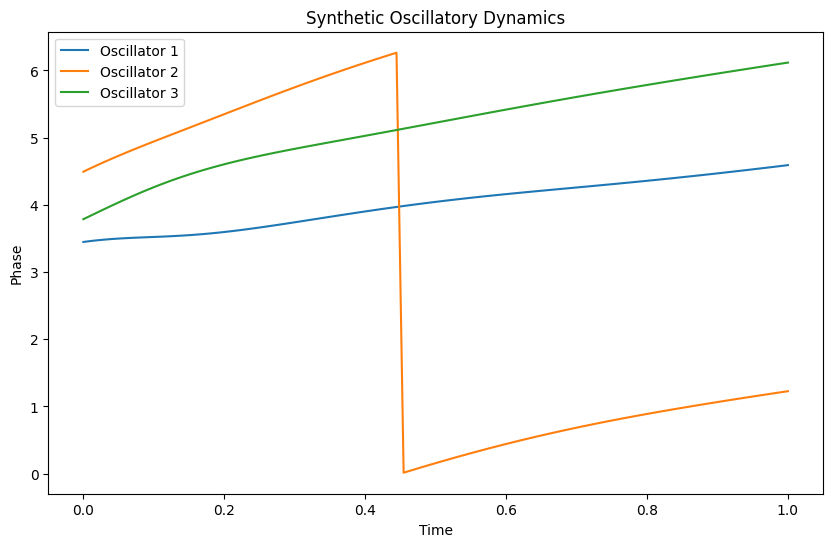

In [1]:
# Generating a Truncated Fourier basis

import numpy as np
import matplotlib.pyplot as plt
import generate_settings

def compute_derivative(phi, w, xi, eta, r):
    """
    Compute the time derivative for each oscillator using vectorized NumPy operations.
    
    Parameters:
        phi : ndarray, shape (N,)
            The current phases of the N oscillators.
        w : ndarray, shape (N,)
            The natural frequencies of the oscillators.
        xi : ndarray, shape (N, N, r)
            Coefficients for the sine terms in the Fourier series.
        eta : ndarray, shape (N, N, r)
            Coefficients for the cosine terms in the Fourier series.
        r : int
            Number of Fourier modes.
    
    Returns:
        phi_dot : ndarray, shape (N,)
            The computed time derivative for each oscillator.
    """
    N = phi.size
    # Compute the phase difference matrix: delta[i, j] = phi[i] - phi[j]
    delta = phi[:, None] - phi[None, :]  # Shape: (N, N)
    
    # Create Fourier mode multipliers (1-indexed)
    modes = np.arange(1, r + 1)  # Shape: (r,)
    
    # Compute sin and cos terms for all pairs (i, j) and all modes
    # Broadcasting: delta[..., None] has shape (N, N, 1) and modes is (r,) -> result is (N, N, r)
    sin_terms = np.sin(delta[..., None] * modes)
    cos_terms = np.cos(delta[..., None] * modes)

    # The functions are defined over an interval of 2 pi length, so the L = pi inside the
    # sine and cosine terms
    
    # Elementwise multiply by the coefficients and sum over the Fourier modes (axis 2)
    interaction_terms = (xi * sin_terms + eta * cos_terms).sum(axis=2)  # Shape: (N, N)
    
    # Exclude self-interaction by setting the diagonal to zero
    np.fill_diagonal(interaction_terms, 0)
    
    # Sum interactions over j for each oscillator
    total_interaction = interaction_terms.sum(axis=1)  # Shape: (N,)
    
    # Combine the intrinsic frequency and interaction terms
    phi_dot = w + total_interaction

    return phi_dot


# phi = np.array([0.4,0.3,0.2])
# w = np.ones(len(phi)) * 0.2
# r = 3 # number of terms in the series
# xi = np.ones((len(phi),len(phi),r)) * 0.3
# eta = np.ones((len(phi),len(phi),r)) * 0.1

# phi_dot = compute_derivative(phi,w,xi,eta,r)

# print("Current step phi:")
# print(phi)

# print(r"Derivative d/dt phi:")
# print(phi_dot)


def wrap_to_2pi(phi):
    """Wrap angles to the interval [0, 2pi]."""
    return phi % (2 * np.pi)
def rk2_step(phi, dt, w, xi, eta, r):
    """
    Perform a single RK2 integration step using
    the trapezoidal method
    
    Parameters:
        phi : ndarray, shape (N,)
            The current phases.
        dt : float
            Time step.
        w, xi, eta, r : parameters for the derivative function.
    
    Returns:
        Updated phi after one RK2 step. It turns the result into
        radians
    """
    k1 = compute_derivative(phi, w, xi, eta, r)
    k2 = compute_derivative(phi + dt/2 * k1, w, xi, eta, r)
    new_phi = phi + dt * k2
    return wrap_to_2pi(new_phi)

# dt = 0.01
# next_step = rk2_step(phi, dt, w,xi,eta,r)
# print("RK2 step:")
# print(next_step)

def simulate_oscillators(N=10, r=3, T=20.0, dt=0.01, settings=None):
    """
    Simulate the dynamics of N oscillators over time T with time step dt.
    
    Parameters:
        N : int
            Number of oscillators.
        r : int
            Number of Fourier modes.
        T : float
            Total simulation time.
        dt : float
            Time step for integration.
        settigs : tuple or None
            If tuple, it must have initial state of the oscillators phi, the natural
            frequencies w, the coefficients of the sine xi, and of the cosine eta.
            Otherwise, these parameters are randomly chosen. 
    
    Returns:
        t_values : ndarray
            Array of time values.
        phi_history : ndarray
            History of oscillator phases (shape: [num_steps, N]).
    """
    num_steps = int(T / dt)

    if settings is None:
        # Initialize phases randomly between 0 and 2π
        phi = np.random.uniform(0, 2*np.pi, size=N)
        
        # Set natural frequencies (e.g., normally distributed around 1.0)
        w = np.random.normal(loc=1.0, scale=0.1, size=N)
        
        # Initialize random Fourier coefficients for interactions
        xi = np.random.rand(N, N, r)
        eta = np.random.rand(N, N, r)

    else: 
        phi, w, xi, eta = settings
    
    # Zero out self-interaction coefficients (i.e., when i == j)
    for i in range(N):
        xi[i, i, :] = 0
        eta[i, i, :] = 0

    t_values = np.linspace(0, T, num_steps)
    phi_history = np.zeros((num_steps, N))
    phi_history[0, :] = phi

    # Integrate using RK2
    for step in range(1, num_steps):
        phi = rk2_step(phi, dt, w, xi, eta, r)
        phi_history[step, :] = phi

    return t_values, phi_history

# settings = phi,w,xi,eta
# t_values, history = simulate_oscillators(N=len(phi), r =r, T=0.03, dt = dt, settings = settings)


# print("In the simulation:")
# print(f"Step 0: {history[0,:]}")
# print(f"Step 1: {history[1,:]}")

# # Run the simulation and plot the results
# if __name__ == '__main__':

r = generate_settings.r
settings = generate_settings.settings
N, T, dt = generate_settings.N, generate_settings.T, generate_settings.dt


t, phi_history = simulate_oscillators(N=len(settings[0]), r=r, T=T, dt=dt, settings = settings)

plt.figure(figsize=(10, 6))
for i in range(phi_history.shape[1]):
    plt.plot(t, phi_history[:, i], label=f'Oscillator {i+1}')
plt.xlabel('Time')
plt.ylabel('Phase')
plt.title('Synthetic Oscillatory Dynamics')
plt.legend()
plt.show()




In [2]:
# Preparing the data for the inference
import generate_synthetic_data

delta_t, back_data, one_sided_data = generate_synthetic_data.data_for_inference(t, phi_history)

print(delta_t.shape, back_data.shape, one_sided_data.shape)

(99,) (99, 3) (98, 3)


In [3]:

# # Inferring the system through least-squares error

# import numpy as np

# def infer_node_dynamics(phi_history, t, r, node_idx, method='one_sided'):
#     """
#     Infer the Fourier coefficients of both self dynamics and interactions 
#     for each oscillator using least squares.
    
#     Model for oscillator i:
#         dphi_i/dt ≈ ω_i +
#             Σ[k=1 to r] { a_{i,k} sin(k*phi_i) + b_{i,k} cos(k*phi_i) } +
#             Σ[j≠i] Σ[k=1 to r] { c_{ij,k} sin(k*(phi_i - phi_j)) + d_{ij,k} cos(k*(phi_i - phi_j)) }
    
#     Parameters:
#         phi_history : ndarray, shape (T, N)
#             Time-series data of phases (each row is a time point, each column an oscillator).
#         t : ndarray, shape (T,)
#             Array of time points corresponding to phi_history.
#         r : int
#             Number of Fourier modes to use.
#             We consider the same number of Fourier modes for self- and node-node relationships
#         node_idx : int
#             Index of the node to process
#         method : str, optional
#             Which finite difference method to use for derivative approximation.
#             Options: 'one_sided' (default) or 'backward'.
    
#     Returns:
#         network_coeffs : list of ndarray
#             A list of length N, where each element is the inferred coefficient vector for oscillator i.
#             The coefficient vector includes:
#                 - 1 constant term (ω_i)
#                 - 2*r terms for self-dynamics
#                 - For each j ≠ i, 2*r terms for the interactions.
#     """

#     # The number of datapoints must be larger than the 

#     # Compute the time derivative using finite differences.
#     if method == 'one_sided':
#         # one-sided finite difference:
#         # Ensure correct operator precedence with parentheses:
#         delta_t = t[1:] - t[:-1]
#         y_data = (3 * phi_history[2:] - 4 * phi_history[1:-1] + phi_history[:-2]) / (2 * delta_t[1:, None])
#         # Use the right-most points for the data points
#         phi_used = phi_history[2:, :]
#     elif method == 'backward':
#         delta_t = t[1:] - t[:-1]
#         y_data = (phi_history[1:, :] - phi_history[:-1, :]) / delta_t[:, None]
#         # use the right points for the data points
#         phi_used = phi_history[1:, :]
#     else:
#         raise ValueError("Unknown derivative method: choose 'one_sided' or 'backward'.")

#     # num_points, N = phi_used.shape Corrected from ChatGPT

#     num_points = y_data.shape[0] # It is the number of numerical derivatives we have
#     N = phi_history.shape[1] # The number of nodes in the system
#     num_coefficients = 2*r - 1 + 2*(r-1)*(N-1) + (N-1)
#     fourier_modes = np.arange(1,r) # the first mode is constant
#     # leaving it without consideration would result in a non-invertible 
#     # design matrix with two columns of 0

#     # self_coefficients are 2*r -1 (one per each sine and cosine, minus the n= 0 for cosine)
#     # node_node_coefficients are 2*(r-1) (one per each sine and cosine, minus the n = 0 ) 
#     # * (N-1) (the number of other nodes) + (N-1) (constatnt terms)

#     network_coeffs = []  # Will store the inferred coefficients for each oscillator.
    
#     # For each oscillator, build the design matrix A_i and solve for z_i.


#     # self-dynamics

#     # First column, constant
#     A_i = np.ones((num_points,1))

#     # data times fourier modes

#     mat_dat_four = np.outer(phi_used[:,node_idx],fourier_modes)
#     # Matrix of shape (num_points, r-1)

#     # sine terms
#     sine_terms_self = np.sin(mat_dat_four)
#     cosine_terms_self = np.cos(mat_dat_four)

#     # Combine the sine and cosine terms with constant

#     A_i = np.hstack((A_i, sine_terms_self, cosine_terms_self))
#     # matrix of shape (num_points, r)

#     # node-node interactions

#     #A_i = np.hsttack

#     # for i in range(num_points):

#     #     #

#     #     # Start with the constant term (column of ones)
#     #     A_i = np.ones((num_points, 1))
        
#     #     # Self dynamics: add Fourier basis functions for oscillator i.
#     #     # For each Fourier mode k, add sin(k*phi_i) and cos(k*phi_i)
#     #     for k in range(1, r + 1):
#     #         A_i = np.hstack((A_i, np.sin(k * phi_used[:, i:i+1])))
#     #         A_i = np.hstack((A_i, np.cos(k * phi_used[:, i:i+1])))
        
#     #     # Interaction terms: for each other oscillator j ≠ i.
#     #     for j in range(N):
#     #         if j == i:
#     #             continue
#     #         # For each Fourier mode k, add sin(k*(phi_i - phi_j)) and cos(k*(phi_i - phi_j))
#     #         for k in range(1, r + 1):
#     #             diff = phi_used[:, i] - phi_used[:, j]
#     #             col_sin = np.sin(k * diff).reshape(-1, 1)
#     #             col_cos = np.cos(k * diff).reshape(-1, 1)
#     #             A_i = np.hstack((A_i, col_sin, col_cos))
        
#         # y vector for oscillator i: the derivative data.
#         y_i = y_data[:, i]
        
#         # Solve the least squares problem: A_i * z_i ≈ y_i
#         z_i, residuals, rank, s = np.linalg.lstsq(A_i, y_i, rcond=None)
#         network_coeffs.append(z_i)
    
#     return network_coeffs

# # Example usage:
# if __name__ == '__main__':
#     # Suppose we have already simulated the data:
#     # t: time array, phi_history: phase history array with shape (num_time_steps, N)
#     # For demonstration, we simulate some dummy data:
#     T = 20.0
#     dt = 0.01
#     t = np.linspace(0, T, int(T/dt))
#     N = 3  # Number of oscillators
#     # For demonstration, let's create synthetic phi_history (in practice, use your simulation)
#     phi_history = np.sin(np.outer(t, np.linspace(1, N, N))) % (2*np.pi)
    
#     # Number of Fourier modes to use in inference:
#     r = 3
#     coeffs = infer_network(phi_history, t, r, method='one_sided')
    
#     # Print the inferred coefficients for each oscillator:
#     for i, c in enumerate(coeffs):
#         print(f"Oscillator {i}:")
#         print(c)

In [4]:
# # Inferring the system through least-squares error

# import numpy as np

# def infer_node_dynamics(phi_history, t, r, node_idx, method='one_sided'):
#     """
#     Infer the Fourier coefficients of both self dynamics and interactions 
#     for each oscillator using least squares.
    
#     Fourier bases for interaction:
#         dphi_i/dt ≈ a_0/sqrt(2pi)+ Σ[k=1 to r] a_k{ sin(k*phi_i) + cos(k*phi_i) }  / sqrt(pi) +
#         Σ[j!=i]Σ[k=1 to r] Σ[l=1 to r] b_klj{ sin(k*phi_i) + cos(k*phi_i) } {sin(l*phi_j) + cos(l*phi_j) } / pi
    
#     Parameters:
#         phi_history : ndarray, shape (T, N)
#             Time-series data of phases (each row is a time point, each column an oscillator).
#         t : ndarray, shape (T,)
#             Array of time points corresponding to phi_history.
#         r : int
#             Number of Fourier modes to use.
#             We consider the same number of Fourier modes for self- and node-node relationships
#         node_idx : int
#             Index of the node to process
#         method : str, optional
#             Which finite difference method to use for derivative approximation.
#             Options: 'one_sided' (default) or 'backward'.
    
#     Returns:
#         network_coeffs : list of ndarray
#             A list of length N, where each element is the inferred coefficient vector for oscillator i.
#             The coefficient vector includes:
#                 - 1 constant term (ω_i)
#                 - 2*r terms for self-dynamics
#                 - For each j ≠ i, 2*r terms for the interactions.
#     """

#     # The number of datapoints must be larger than the 

#     # Compute the time derivative using finite differences.
#     if method == 'one_sided':
#         # one-sided finite difference:
#         # Ensure correct operator precedence with parentheses:
#         delta_t = t[1:] - t[:-1]
#         y_data = (3 * phi_history[2:, node_idx] - 4 * phi_history[1:-1, node_idx] + phi_history[:-2, node_idx]) / (2 * delta_t[1:, None])
#         # Use the right-most points for the data points
#         phi_used = phi_history[2:, :]
#     elif method == 'backward':
#         delta_t = t[1:] - t[:-1]
#         y_data = (phi_history[1:, node_idx] - phi_history[:-1, node_idx]) / delta_t[:, None]
#         # use the right points for the data points
#         phi_used = phi_history[1:, :]
#     else:
#         raise ValueError("Unknown derivative method: choose 'one_sided' or 'backward'.")

#     # num_points, N = phi_used.shape Corrected from ChatGPT

#     num_points = y_data.shape[0] # It is the number of numerical derivatives we have
#     N = phi_history.shape[1] # The number of nodes in the system
#     num_coefficients = r + (r-1) * (N-1)**2

#     # There are r terms in the self-relationship
#     # There are (r-1) * (N-1)**2 terms in the node-node relationships that are not
#     # the constant term
#     # There are N-1 terms in the node-node relationships that are constant terms

#     fourier_modes = np.arange(1,r) # the first mode is constant!

#     # Create the self-dynamics matrix
#     A_i = np.ones((num_points, 1)) / np.sqrt(2*np.pi) # The constant term.
#     mat_dat_four = np.outer(phi_used[:,node_idx],fourier_modes)
#     sine_terms = np.sin(mat_dat_four)
#     cosine_terms = np.cos(mat_dat_four)
#     orthonormal_terms = (sine_terms + cosine_terms) / np.sqrt(np.pi)
#     A = np.hstack((A_i, orthonormal_terms)) 
#     # append a matrix of shape (num_points, r)
#     # we will stack the other matrices here too 
    
#     for mode_1 in fourier_modes:

#         P_mode_1 = (np.sin(phi_used[:node_idx] * mode_1) + np.cos(phi_used[:node_idx] * mode_1)) / np.sqrt(np.pi)
#         # Shape (num_points,1)

#         mat_data_others = np.delete(phi_used, node_idx, axis = 1)

#         for mode_2 in fourier_modes:
#             P_mode_2 = (np.sin(mat_data_others * mode_2) + np.cos(mat_data_others * mode_2)) / np.sqrt(np.pi)
#             # shape (num_points, N-1)

#             O_kl = P_mode_1 * P_mode_2
#             # shape (num_points, N-1)

#             A = np.hstack((A, O_kl))

#     # for node_jdx in range(N):
#     #     # Node node relationships
#     #     if node_jdx != node_idx:
#     #         # No Constant terms! They must be in the self-relationship
#     #         #A_i = np.ones((num_points, 1)) / np.sqrt(2*np.pi) # The constant term.
            
#     #         # Evaluate the current index data

#     #         mat_data_j = np.outer(phi_used[:, node_jdx], fourier_modes)
#     #         sine_terms_j = np.sin(mat_data_j)
#     #         cosine_terms_j = np.cos(mat_data_j)
#     #         orthonormal_terms_j = (sine_terms_j + cosine_terms_j) / np.sqrt(np.pi)
#     #         # Shape (num_points, r-1)

#     #         mat_dat_i = np.outer(phi_used[:,node_idx],fourier_modes)
#     #         sine_terms_i = np.sin(mat_dat_i)
#     #         cosine_terms_i = np.cos(mat_dat_i)
#     #         orthonormal_terms_i = (sine_terms_i + cosine_terms_i) / np.sqrt(np.pi)
#     #         # Shape (num_points, r-1)
#     #         A = np.hstack((A, orthonormal_terms_j*orthonormal_terms_i)) 
#     #         # append a matrix of shape (num_points, (r-1)), N-1 times

#     # after the loop, the design matrix must have shape (num_points, r + (r-1)**2 * (N-1))

#     # Use least squares to solve for the coefficients
#     coefficients, residuals, rank, singular_vals = np.linalg.lstsq(A, y_data, rcond=None)    
    
#     # coefficients must be a vector of length (r + (r-1)                                * (N-1))

#     return coefficients

# # # Example usage:
# # if __name__ == '__main__':
# #     # Suppose we have already simulated the data:
# #     # t: time array, phi_history: phase history array with shape (num_time_steps, N)
# #     # For demonstration, we simulate some dummy data:
# #     T = 20.0
# #     dt = 0.01
# #     t = np.linspace(0, T, int(T/dt))
# #     N = 3  # Number of oscillators
# #     # For demonstration, let's create synthetic phi_history (in practice, use your simulation)
# #     phi_history = np.sin(np.outer(t, np.linspace(1, N, N))) % (2*np.pi)
    
# #     # Number of Fourier modes to use in inference:
# #     r = 3
# #     coeffs = infer_network(phi_history, t, r, method='one_sided')
    
# #     # Print the inferred coefficients for each oscillator:
# #     for i, c in enumerate(coeffs):
# #         print(f"Oscillator {i}:")
# #         print(c)



In [5]:
# import numpy as np

# def infer_node_dynamics(phi_history, t, r, node_idx, method='backward'):
#     """
#     Infer the Fourier coefficients of both self dynamics and interactions 
#     for oscillator `node_idx` using least squares.

#     Model (product-based expansions):
#         dphi_i/dt ≈ a0 / sqrt(2π)
#                     + Σ[k=1..r] ak / sqrt(π)*[sin(k phi_i) + cos(k phi_i)]
#                     + Σ[j≠i] Σ[k=1..r] Σ[l=1..r] b_{k,l,j}/π * [sin(k phi_i)+cos(k phi_i)]*[sin(l phi_j)+cos(l phi_j)]
#     """
#     # 1) Compute finite differences for dphi_i/dt
#     if method == 'one_sided':
#         delta_t = t[1:] - t[:-1]
#         # shape = (T-2,) for the relevant time points
#         y_data = (3*phi_history[2:, node_idx]
#                   - 4*phi_history[1:-1, node_idx]
#                   + phi_history[:-2, node_idx]) / (2*delta_t[1:])
#         phi_used = phi_history[2:, :]
#     elif method == 'backward':
#         delta_t = t[1:] - t[:-1]
#         y_data = (phi_history[1:, node_idx] - phi_history[:-1, node_idx]) / delta_t
#         phi_used = phi_history[1:, :]
#     else:
#         raise ValueError("Unknown method. Choose 'one_sided' or 'backward'.")

#     num_points = y_data.shape[0]
#     N = phi_history.shape[1]

#     # ---------------------------
#     # 2) Build expansions for phi_i (the “self” node)
#     # ---------------------------
#     # Constant term a0/sqrt(2π):
#     A_const = np.ones((num_points, 1)) / np.sqrt(2*np.pi)
#     # For k=1..r, the bracket [sin(k phi_i) + cos(k phi_i)] / sqrt(π)
#     modes = np.arange(1, r+1)  # so it includes k=r
#     mat_i = np.outer(phi_used[:, node_idx], modes)          # shape = (num_points, r)
#     sin_i = np.sin(mat_i)
#     cos_i = np.cos(mat_i)
#     self_expansions = (sin_i + cos_i) / np.sqrt(np.pi)      # shape = (num_points, r)

#     # Combine them into the partial design matrix for self:
#     # shape = (num_points, 1 + r)
#     A_self = np.hstack([A_const, self_expansions])

#     # ---------------------------
#     # 3) Build expansions for each neighbor (j != i), then combine
#     # ---------------------------
#     # We want the bracket [sin(l phi_j)+cos(l phi_j)] for l=1..r, for each j != i.
#     # We'll gather them all side by side, so we get shape = (num_points, r*(N-1)).
#     mask_others = np.arange(N) != node_idx
#     phi_others = phi_used[:, mask_others]   # shape (num_points, N-1)

#     # For each row, multiply by each mode => shape (num_points, (N-1), r)
#     # Then sum sin+cos => shape still (num_points, (N-1), r)
#     # We'll then reshape to 2D so each oscillator j's expansions line up horizontally.
#     # (This lumps sin and cos into one bracket. If you want them separate, handle them individually.)
#     # Expand dims to broadcast modes:
#     mat_others_3d = phi_others[..., None] * modes  # shape (num_points, N-1, r)
#     sin_others_3d = np.sin(mat_others_3d)
#     cos_others_3d = np.cos(mat_others_3d)
#     expansions_others_3d = (sin_others_3d + cos_others_3d) / np.sqrt(np.pi)
#     # reshape from (num_points, N-1, r) -> (num_points, (N-1)*r)
#     expansions_others_2d = expansions_others_3d.reshape(num_points, -1)

#     # ---------------------------
#     # 4) Form the product of expansions_i with expansions_others
#     # ---------------------------
#     # We have self_expansions (num_points, r) and expansions_others_2d (num_points, r*(N-1)).
#     # We want the pairwise products => shape (num_points, r * [r*(N-1)]) = (num_points, r^2*(N-1))
#     # If we want them all as separate columns, we can do:
#     self_3d = self_expansions.reshape(num_points, r, 1)
#     others_3d = expansions_others_2d.reshape(num_points, 1, r*(N-1))
#     product_3d = self_3d * others_3d  # shape (num_points, r, r*(N-1))
#     product_3d_alt = product_3d.transpose(0, 2, 1)# shape (num_points, r*(N-1), r)
#     # In product_3d_alt, the third dimension corresponds to the index i in O_ij,
#     # where the second dimension corresponds to the index j
#     product_2d = product_3d_alt.reshape(num_points, -1)  # flatten the last two dims
#     # In the flatten, we end up with [O_11, O_12, O_13,... O_rr-1, O_rr]

#     # Now combine everything:
#     # A_self has shape (num_points, 1 + r) => the constant + self expansions
#     # product_2d has shape (num_points, r^2*(N-1))
#     A = np.hstack([A_self, product_2d])

#     # Resultant A should have shape (num_points, 1+r+r^2*(N-1))

#     # ---------------------------
#     # 5) Solve least-squares: A x ~ y_data
#     # ---------------------------
#     # y_data shape is (num_points,), so we can do:
#     x_sol, residuals, rank, svals = np.linalg.lstsq(A, y_data, rcond=None)

#     return x_sol, residuals


In [6]:
import numpy as np

def infer_node_dynamics(phi_history, t, r, node_idx, method='backward'):
    """
    Infer the Fourier coefficients of both self-dynamics and pairwise interactions
    for a single oscillator in a network of phase oscillators.

    Parameters
    ----------
    phi_history : ndarray, shape (T, N)
        Time series of phase angles for N oscillators, sampled at T time points.
    t : ndarray, shape (T,)
        Array of time points corresponding to each row in phi_history.
    r : int
        Maximum Fourier mode to include for expansions.
    node_idx : int
        Index of the oscillator to be inferred (0 <= node_idx < N).
    method : {'backward', 'one_sided'}, optional
        Numerical differentiation method:
            - 'backward': (phi[i+1] - phi[i]) / Δt
            - 'one_sided': (3*phi[i+2] - 4*phi[i+1] + phi[i]) / (2*Δt)
        Defaults to 'backward'.

    Returns
    -------
    x_sol : ndarray, shape (1 + r + r^2*(N-1),)
        The least-squares solution vector. The first (1 + r) entries correspond
        to the “self” dynamics coefficients (constant term + r Fourier modes).
        The remaining r^2*(N-1) entries are the pairwise interaction coefficients
        for all other oscillators j != node_idx.
    residuals : ndarray
        Sum of squared residuals of the least-squares solution. 
        (Empty if the solution is a perfect fit or T <= # parameters.)
    """
    # -------------------------------------------------------------------------
    # 0) Validate inputs
    # -------------------------------------------------------------------------
    valid_methods = ['one_sided', 'backward']
    if method not in valid_methods:
        raise ValueError(f"Unknown method '{method}'. Choose from {valid_methods}.")

    # Check shapes
    if len(t) != phi_history.shape[0]:
        raise ValueError("Time array length must match the first dimension of phi_history.")
    if node_idx < 0 or node_idx >= phi_history.shape[1]:
        raise IndexError("node_idx is out of bounds for the second dimension of phi_history.")
    if r < 1:
        raise ValueError("r must be >= 1.")

    # Check we have enough data points for the chosen method
    T = phi_history.shape[0]
    if method == 'one_sided' and T < 3:
        raise ValueError("one_sided method requires at least 3 time points.")
    if method == 'backward' and T < 2:
        raise ValueError("backward method requires at least 2 time points.")

    # -------------------------------------------------------------------------
    # 1) Compute finite differences for dphi_i/dt (for the chosen method)
    # -------------------------------------------------------------------------
    if method == 'one_sided':
        # y_data shape -> (T-2,)
        delta_t = t[1:] - t[:-1]               # shape (T-1,)
        if len(delta_t) < 2:
            raise ValueError("Insufficient time points for 'one_sided' differencing.")
        # phi[i+2], phi[i+1], phi[i]
        y_data = (3.0 * phi_history[2:, node_idx]
                  - 4.0 * phi_history[1:-1, node_idx]
                  +        phi_history[:-2, node_idx]) / (2.0 * delta_t[1:])
        phi_used = phi_history[2:, :]         # shape (T-2, N)

    else:  # method == 'backward'
        # y_data shape -> (T-1,)
        delta_t = t[1:] - t[:-1]              # shape (T-1,)
        y_data = ((phi_history[1:, node_idx]
                  - phi_history[:-1, node_idx]) / delta_t)
        phi_used = phi_history[1:, :]         # shape (T-1, N)

    num_points = y_data.shape[0]
    N = phi_used.shape[1]

    # -------------------------------------------------------------------------
    # 2) Build expansions for the “self” node (i = node_idx)
    # -------------------------------------------------------------------------
    # a0 / sqrt(2π)
    A_const = np.ones((num_points, 1)) / np.sqrt(2.0 * np.pi)

    # For k=1..r, we have sin(k phi_i) + cos(k phi_i), scaled by 1/sqrt(π)
    modes = np.arange(1, r + 1)  # array([1, 2, ..., r])
    mat_i = np.outer(phi_used[:, node_idx], modes)  # shape (num_points, r)
    sin_i = np.sin(mat_i)
    cos_i = np.cos(mat_i)
    self_expansions = (sin_i + cos_i) / np.sqrt(np.pi)  # shape (num_points, r)

    # Combine into one partial design matrix for self: shape (num_points, 1 + r)
    A_self = np.hstack([A_const, self_expansions])

    # -------------------------------------------------------------------------
    # 3) Build expansions for each “other” node (j != i)
    #    bracket: [sin(l phi_j) + cos(l phi_j)] for l = 1..r
    # -------------------------------------------------------------------------
    mask_others = (np.arange(N) != node_idx)  
    phi_others = phi_used[:, mask_others]  # shape (num_points, N-1)

    # Expand in 3D for sin & cos
    mat_others_3d = phi_others[..., None] * modes  # shape (num_points, (N-1), r)
    sin_others_3d = np.sin(mat_others_3d)
    cos_others_3d = np.cos(mat_others_3d)

    expansions_others_3d = (sin_others_3d + cos_others_3d) / np.sqrt(np.pi)
    # Flatten across all j != i
    # shape from (num_points, (N-1), r) -> (num_points, (N-1)*r)
    expansions_others_2d = expansions_others_3d.reshape(num_points, -1)

    # -------------------------------------------------------------------------
    # 4) Form product of expansions_i with expansions_others => (num_points, r^2*(N-1))
    #    This is the pairwise term: [self_expansion_k * other_expansion_(k')]
    # -------------------------------------------------------------------------
    self_3d = self_expansions.reshape(num_points, r, 1)           # (num_points, r, 1)
    others_3d = expansions_others_2d.reshape(num_points, 1, r*(N-1))
    product_3d = self_3d * others_3d  # shape (num_points, r, r*(N-1))

    # Transpose so the middle axis lines up the “r*(N-1)” dimension nicely
    product_3d_alt = product_3d.transpose(0, 2, 1)  # (num_points, r*(N-1), r)

    # Flatten the last two dimensions => (num_points, r^2*(N-1))
    product_2d = product_3d_alt.reshape(num_points, -1)

    # -------------------------------------------------------------------------
    # 5) Combine design matrices: A = [ A_self | product_2d ]
    #    shape => (num_points, 1 + r + r^2*(N-1))
    # -------------------------------------------------------------------------
    A = np.hstack([A_self, product_2d])

    # -------------------------------------------------------------------------
    # 6) Solve for coefficients in least squares sense
    # -------------------------------------------------------------------------
    x_sol, residuals, rank, svals = np.linalg.lstsq(A, y_data, rcond=None)

    if not residuals:
        print("Something went wrong!")
    return x_sol, residuals


In [18]:
import generate_synthetic_data

t_vals, phi_vals = generate_synthetic_data.run_simulation()
print(t_vals.shape)
# Inferring the coefficient

inferred_coefficient, error = infer_node_dynamics(phi_vals, t_vals, 3, 1, method = 'backward')
error

(100,)


array([320103.64383382])

In [9]:
inferred_coefficient.shape

(37,)